In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
image_size=256
batch_size=32
Channels=3
Epochs=50

In [3]:
df=tf.keras.preprocessing.image_dataset_from_directory('plantvillage',shuffle=True,image_size=(image_size,image_size),batch_size=batch_size)

Found 3630 files belonging to 3 classes.


In [4]:
class_names=df.class_names

In [5]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch,label_batch in df.take(1):
    print(image_batch[0].shape)
    print(image_batch[0].numpy())

(256, 256, 3)
[[[162. 154. 165.]
  [161. 153. 164.]
  [160. 152. 163.]
  ...
  [ 97.  86. 100.]
  [116. 105. 119.]
  [121. 110. 124.]]

 [[161. 153. 164.]
  [161. 153. 164.]
  [161. 153. 164.]
  ...
  [ 84.  73.  87.]
  [ 96.  85.  99.]
  [ 91.  80.  94.]]

 [[160. 152. 163.]
  [161. 153. 164.]
  [161. 153. 164.]
  ...
  [ 87.  76.  90.]
  [ 95.  84.  98.]
  [ 87.  76.  90.]]

 ...

 [[153. 143. 154.]
  [156. 146. 157.]
  [159. 149. 160.]
  ...
  [115. 105. 116.]
  [111. 101. 112.]
  [105.  95. 106.]]

 [[158. 148. 159.]
  [158. 148. 159.]
  [157. 147. 158.]
  ...
  [113. 103. 114.]
  [107.  97. 108.]
  [100.  90. 101.]]

 [[165. 155. 166.]
  [160. 150. 161.]
  [155. 145. 156.]
  ...
  [120. 110. 121.]
  [116. 106. 117.]
  [110. 100. 111.]]]


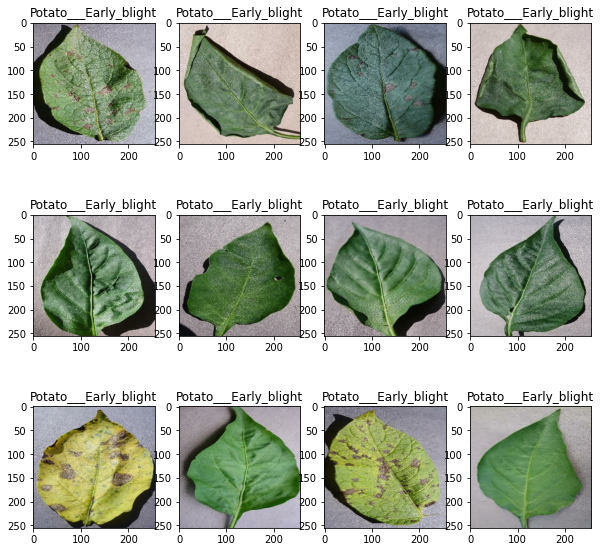

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in df.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])

In [8]:
len(df)

114

In [9]:
68*32

2176

In [10]:
def partitions_tf(df,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    df_size=len(df)
    if shuffle:
        df=df.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*df_size)
    val_size=int(val_split*df_size)
    train_df=df.take(train_size)
    val_df=df.skip(train_size).take(val_size)
    test_df=df.skip(train_size).skip(val_size)
    return train_df,val_df,test_df

In [11]:
train_df,val_df,test_df=partitions_tf(df)

In [12]:
print('train_df:',len(train_df))
print('val_df:',len(val_df))
print('test_df:',len(test_df))

train_df: 91
val_df: 11
test_df: 12


In [13]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
#preprocessing
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size,image_size),
  layers.experimental.preprocessing.Rescaling(1./255),#images are converting to 0 to 1
])
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
#apply data augu for train dataset
train_df = train_df.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [16]:
input_shape = (batch_size,image_size,image_size,Channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_df,
    epochs=20,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_df,
    
)

Epoch 1/20
91/91 [==============================] - 796s 8s/step - loss: 0.7665 - accuracy: 0.6690 - val_loss: 0.7801 - val_accuracy: 0.6449
Epoch 2/20
91/91 [==============================] - 805s 9s/step - loss: 0.6724 - accuracy: 0.6949 - val_loss: 0.7476 - val_accuracy: 0.7670
Epoch 3/20
91/91 [==============================] - 901s 10s/step - loss: 0.3909 - accuracy: 0.8673 - val_loss: 0.4266 - val_accuracy: 0.8523
Epoch 4/20
91/91 [==============================] - 720s 8s/step - loss: 0.3126 - accuracy: 0.8956 - val_loss: 0.4133 - val_accuracy: 0.8722
Epoch 5/20
91/91 [==============================] - 696s 8s/step - loss: 0.2752 - accuracy: 0.9039 - val_loss: 0.2873 - val_accuracy: 0.9062
Epoch 6/20
91/91 [==============================] - 715s 8s/step - loss: 0.2321 - accuracy: 0.9171 - val_loss: 0.2987 - val_accuracy: 0.9006
Epoch 7/20
91/91 [==============================] - 926s 10s/step - loss: 0.1889 - accuracy: 0.9299 - val_loss: 0.3856 - val_accuracy: 0.8778
Epoch 8/20


In [22]:
scores=model.evaluate(test_df)

12/12 [==============================] - 26s 2s/step - loss: 0.1051 - accuracy: 0.9688


In [24]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

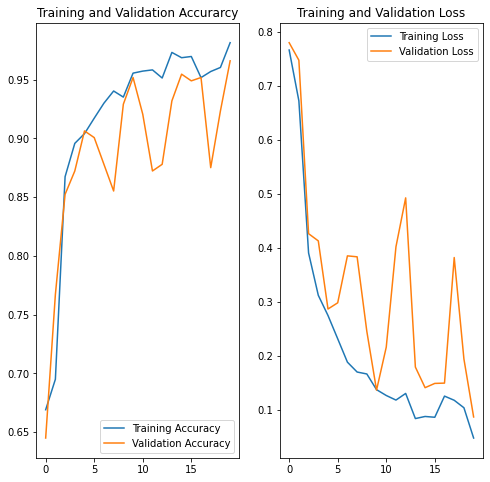

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(20),acc,label='Training Accuracy')
plt.plot(range(20),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accurarcy')
plt.subplot(1,2,2)
plt.plot(range(20),loss,label='Training Loss')
plt.plot(range(20),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

actual label: Potato___Early_blight
1/1 [==============================] - 4s 4s/step
predicted label: Potato___Early_blight


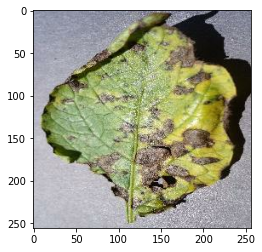

In [26]:
import numpy as np
for image_batch,label_batch in test_df.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction=model.predict(image_batch)
    print('predicted label:',class_names[np.argmax(batch_prediction[0])])
    

In [29]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence
    

1/1 [==============================] - 0s 94ms/step


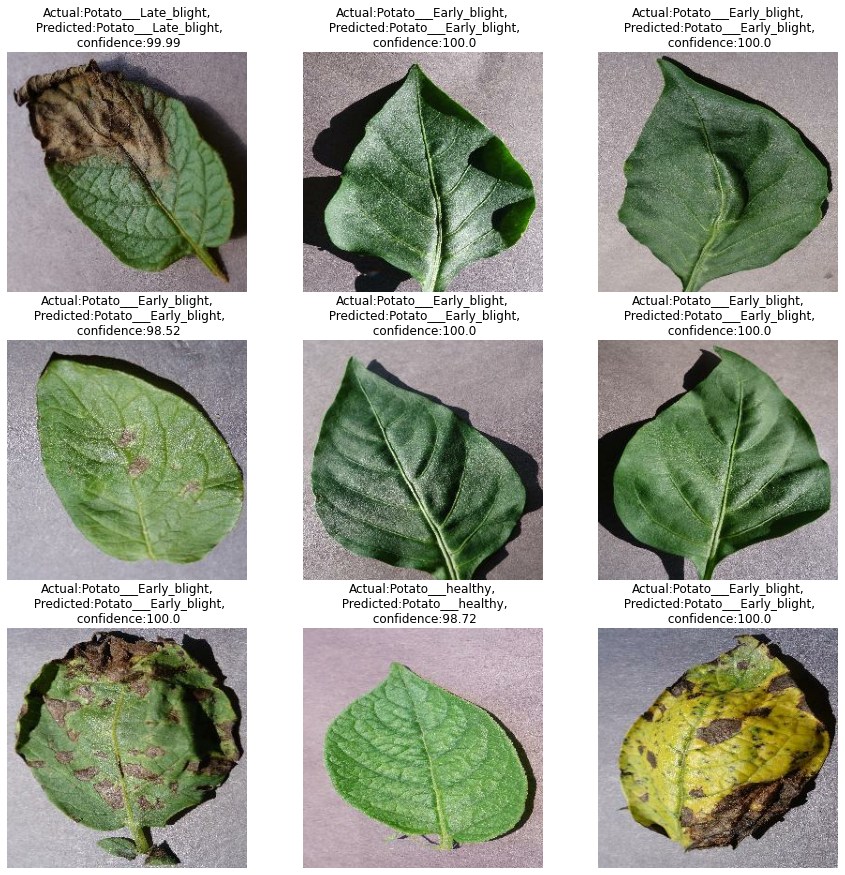

In [30]:
plt.figure(figsize=(15,15))
for images,labels in test_df.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n confidence:{confidence}")
        plt.axis("off")